<a href="https://colab.research.google.com/github/arashms/DL-project/blob/densebasenet/COVID_Regulations_Regression_NoComment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install and Import libraries and define parameters

### Install & Import Libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 12.4MB/s 
     |████████████████████████████████| 901kB 49.1MB/s 
     |████████████████████████████████| 3.3MB 41.6MB/s 


In [154]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import csv 
import random
from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertForNextSentencePrediction, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from scipy import stats
import time
import datetime
import pickle
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import gc
import itertools
import nltk
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, f1_score, precision_score, mean_absolute_error, mean_squared_error, r2_score
# nltk.download('punkt')

### Setting Parameters

In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/DL-Project/'
save_path = '/content/drive/MyDrive/Colab Notebooks/DL-Project/'

epochs = 1
batch_size = 16
learning_rate = 1e-6

validation_ratio = 0.2

max_length = 128
max_sentence_length = 64

### Setting device, random seed, and runtime parameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Cuda available: ",torch.cuda.is_available())
if torch.cuda.is_available():
    print("Current device: ",  torch.cuda.current_device())

seed = 204920
seed2 = 293652

random.seed(seed2)
np.random.seed(seed2)
torch.manual_seed(seed2)

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed)

Cuda available:  True
Current device:  0


# 2. Reading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [118]:
from sklearn.preprocessing import LabelEncoder as le
!cp  "/content/drive/MyDrive/Colab Notebooks/DL-Project/Combined.xlsx" Combined.xlsx
!cp  "/content/drive/MyDrive/Colab Notebooks/DL-Project/acaps_covid19_government_measures_dataset_0.xlsx" acaps_covid19_government_measures_dataset_0.xlsx

xl_file = pd.ExcelFile('acaps_covid19_government_measures_dataset_0.xlsx')

sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

dataframe = sheets['Dataset']

print('Sheets in the dataset:   ', sheets.keys())
print('Number of regulations in the dataset: ', len(dataframe), '\n')

print(dataframe.head())
print('\n', dataframe.info(), '\n')

# print(list(dataframe['ID'][0:10]))
# print(dataframe.iloc[0])

dataset = {}
for key in dataframe:
    # dataframe[key] = le.fit_transform(dataframe[key].astype(str))
    dataframe[key]=dataframe[key].astype('str')
    dataset[key] = list(dataframe[key])


Sheets in the dataset:    dict_keys(['About', 'Dataset', 'Dictionary'])
Number of regulations in the dataset:  23923 

     ID  ISO  ... ENTRY_DATE Alternative source
0  7560  CHE  ... 2020-04-25                NaN
1  7561  CHE  ... 2020-04-25                NaN
2  7562  CHE  ... 2020-04-25                NaN
3  7555  CHE  ... 2020-04-25                NaN
4  7556  CHE  ... 2020-04-25                NaN

[5 rows x 18 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23923 entries, 0 to 23922
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  23923 non-null  int64         
 1   ISO                 23923 non-null  object        
 2   COUNTRY             23923 non-null  object        
 3   REGION              23923 non-null  object        
 4   ADMIN_LEVEL_NAME    3682 non-null   object        
 5   PCODE               0 non-null      float64       
 6   LOG_TYPE

# 3. Processing the dataset

### Some statistics of the dataset

In [119]:
def get_frequency_stat(attr):

    freq_dic = {}
    for value in dataset[attr]:
        if value in freq_dic:
            freq_dic[value] += 1
        else:
            freq_dic[value] = 1
    
    values = []
    freqs = []

    for key in freq_dic:
        values.append(key)
        freqs.append(freq_dic[key])

    freqs, values = (list(t) for t in zip(*sorted(zip(freqs, values))))
    freqs, values = freqs[::-1], values[::-1]
    sumf = sum(freqs)

    print('\nFrequency Stat of ', attr)
    print('Number of different values: ', len(values), '\n')

    for i in range(min(len(values), 10)):
        print(values[i], ': %', 100 * freqs[i] / sumf)


# print(dataframe['SOURCE'].value_counts())
for key in dataset:
    get_frequency_stat(key)



Frequency Stat of  ID
Number of different values:  23923 

9999 : % 0.00418007774944614
9998 : % 0.00418007774944614
9997 : % 0.00418007774944614
9996 : % 0.00418007774944614
9995 : % 0.00418007774944614
9994 : % 0.00418007774944614
9993 : % 0.00418007774944614
9992 : % 0.00418007774944614
9991 : % 0.00418007774944614
9990 : % 0.00418007774944614

Frequency Stat of  ISO
Number of different values:  193 

GBR : % 2.7379509258872217
AUS : % 2.3157630731931613
USA : % 2.03569786398027
PHL : % 1.910295531496886
DNK : % 1.5006479120511642
CAN : % 1.379425657317226
NZL : % 1.2665635580821804
LKA : % 1.2665635580821804
PRT : % 1.228942858337165
MYS : % 1.2164026250888267

Frequency Stat of  COUNTRY
Number of different values:  193 

United Kingdom : % 2.7379509258872217
Australia : % 2.3157630731931613
United States : % 2.03569786398027
Philippines : % 1.910295531496886
Denmark : % 1.5006479120511642
Canada : % 1.379425657317226
Sri Lanka : % 1.2665635580821804
New Zealand : % 1.266563558082

### Classifying regulations based on Measure and Category

In [120]:
regulation_types = {}

for i in range(len(dataset['ID'])):

    category = dataset['CATEGORY'][i]
    measure = dataset['MEASURE'][i]

    if category not in regulation_types:
        regulation_types[category] = {}
    
    if measure not in regulation_types[category]:
        regulation_types[category][measure] = []
    
    regulation_types[category][measure].append(i)

for category in regulation_types:

    print(len(regulation_types[category]))
    
    for measure in regulation_types[category]:
        print('CATEGORY: ', category, ' MEASURE: ', measure, ' %',
              100 * len(regulation_types[category][measure]) / len(dataset['ID']) )


5
CATEGORY:  Governance and socio-economic measures  MEASURE:  Economic measures  % 12.456631693349497
CATEGORY:  Governance and socio-economic measures  MEASURE:  Military deployment  % 0.46816870793796767
CATEGORY:  Governance and socio-economic measures  MEASURE:  State of emergency declared  % 1.9646365422396856
CATEGORY:  Governance and socio-economic measures  MEASURE:  Emergency administrative structures activated or established  % 3.0639969903440205
CATEGORY:  Governance and socio-economic measures  MEASURE:  Limit product imports/exports  % 0.28842536471178365
12
CATEGORY:  Public health measures  MEASURE:  Testing policy  % 2.5038665719182376
CATEGORY:  Public health measures  MEASURE:  Psychological assistance and medical social work  % 0.597751118170798
CATEGORY:  Public health measures  MEASURE:  Isolation and quarantine policies  % 5.726706516741212
CATEGORY:  Public health measures  MEASURE:  Requirement to wear protective gear in public  % 2.98875559085399
CATEGORY:  Pu

# 4. Comment embeddings from DeBerta model

### Loading Comments

In [121]:
xl_file = pd.ExcelFile("acaps_covid19_government_measures_dataset_0.xlsx")

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}


dataset = dfs['Dataset']

# using ids list you can find the id of each comment
not_null_ids = list(dataset.loc[dataset['COMMENTS'].notna()]["ID"])

# the list contating all not nan comments
comments = list(dataset.loc[dataset['COMMENTS'].notna()]["COMMENTS"])

print(f'number of relugations that the their comment is not null {len(comments)}')

number of relugations that the their comment is not null 23799


### Tokenizing

In [122]:
tokenizer = transformers.DebertaTokenizer.from_pretrained('microsoft/deberta-base') 
max_length = 64
train_encodings = tokenizer(comments, add_special_tokens=True, return_token_type_ids=False, truncation=True, padding=True, max_length=max_length)

### Creating pytorch Dataset

In [123]:
class NSPDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
#         self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         if self.labels != None:
#           item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        # return len(self.labels)
        return len(self.encodings['input_ids'])

In [124]:
train_dataset = NSPDataset(train_encodings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

### Creating DeBerta Model

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = transformers.DebertaModel.from_pretrained('microsoft/deberta-base')


if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = torch.nn.DataParallel(model)
    
model.to(device)
model.train()

DebertaModel(
  (embeddings): DebertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=0)
    (LayerNorm): DebertaLayerNorm()
    (dropout): StableDropout()
  )
  (encoder): DebertaEncoder(
    (layer): ModuleList(
      (0): DebertaLayer(
        (attention): DebertaAttention(
          (self): DisentangledSelfAttention(
            (in_proj): Linear(in_features=768, out_features=2304, bias=False)
            (pos_dropout): StableDropout()
            (pos_proj): Linear(in_features=768, out_features=768, bias=False)
            (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): StableDropout()
          )
          (output): DebertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): DebertaLayerNorm()
            (dropout): StableDropout()
          )
        )
        (intermediate): DebertaIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bia

### Generating Comment Embeddings

In [126]:
all_cls = []

for iteration, batch in tqdm(enumerate(train_loader)):
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    
    with torch.no_grad():
        
        last_hidden_state = model(input_ids, attention_mask=attention_mask).last_hidden_state
        cls_tokens = last_hidden_state[:,0,:].detach()
        
        all_cls.append(cls_tokens)

        
# out_cls is a matrix of size number_of_not_null_comments (23799) X size_of_hidden_state_of_BERT (768)
# In this matrix, for each comment we have an embedding vector.
# Use "ids" list to map each comment with its ids.
out_cls = torch.cat(all_cls, 0)

print("shape of output matrix :", out_cls.shape)

744it [00:33, 22.19it/s]

shape of output matrix : torch.Size([23799, 768])


# 5. Preparing Input and Output Features

### Creating feature maps

In [127]:
category_map = {}
measure_map = {}
log_type_map = {}

for i in range(len(dataset['ID'])):

    category = dataset['CATEGORY'][i]
    measure = dataset['MEASURE'][i]
    log_type =dataset['LOG_TYPE'][i]

    if category not in category_map:
        category_map[category] = len(category_map.keys())
    
    if measure not in measure_map:
        measure_map[measure] = len(measure_map.keys())

    if log_type not in log_type_map:
        log_type_map[log_type] = len(log_type_map.keys())


id2index_map = {}

for index, id in enumerate(dataset['ID']):
    id2index_map[id] = index

### Preparing input features

In [128]:
message_embeddings = out_cls.tolist()
categories = []
measures = []
log_types = []

for id in not_null_ids:
    index = id2index_map[id]

    category = category_map[dataset['CATEGORY'][index]]
    one_hot_category = [0 for i in range(len(category_map.keys()))]
    one_hot_category[category] = 1
    categories.append(one_hot_category)

    measure = measure_map[dataset['MEASURE'][index]]
    one_hot_measure = [0 for i in range(len(measure_map.keys()))]
    one_hot_measure[measure] = 1
    measures.append(one_hot_measure)

    log_type = log_type_map[dataset['LOG_TYPE'][index]]
    log_types.append(log_type)


### Reading combined dataset & Preparing output labels

In [129]:
xl_file = pd.ExcelFile('/content/Combined.xlsx')

sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

dataframe = sheets['Policy']

print('Sheets in the dataset:   ', sheets.keys())
print('Number of regulations in the dataset: ', len(dataframe), '\n')

print(dataframe.head())
# print('\n', dataframe.info(), '\n')

combined_dataset = {}
for key in dataframe:
    dataframe[key]=dataframe[key].astype('str')
    combined_dataset[key] = list(dataframe[key])

Sheets in the dataset:    dict_keys(['Cases', 'Policy', 'HyperParam', 'Summary'])
Number of regulations in the dataset:  23923 

      ID  ISO            COUNTRY  ...    Dleta Delta_percent  Label_percent
0   1448  TUR             Turkey  ... -15576.0     -1.998717            0.0
1   2509  USA      United States  ...  -9083.0     -1.998680            0.0
2   2620  USA      United States  ...  -6455.0     -1.998143            0.0
3  15613  GNQ  Equatorial Guinea  ...  -1750.0     -2.000000            0.0
4   9941  TJK         Tajikistan  ...  -1499.0     -2.000000            0.0

[5 rows x 42 columns]


In [138]:
id2label = {}
id2history = {}
for i in range(len(combined_dataset['ID'])):
    id2label[int(combined_dataset['ID'][i])] = combined_dataset['Delta_percent'][i]
    id2history[int(combined_dataset['ID'][i])] = [float(combined_dataset['D1'][i]),
                                                  float(combined_dataset['D2'][i]),
                                                  float(combined_dataset['D3'][i]),
                                                  float(combined_dataset['D4'][i]),
                                                  float(combined_dataset['D5'][i]),
                                                  float(combined_dataset['D6'][i]),
                                                  float(combined_dataset['D7'][i]),
                                                  float(combined_dataset['D8'][i]),
                                                  float(combined_dataset['D9'][i]),
                                                  float(combined_dataset['D10'][i]),
                                                  float(combined_dataset['D11'][i]),
                                                  float(combined_dataset['D12'][i]),
                                                  float(combined_dataset['D13'][i]),
                                                  float(combined_dataset['D14'][i])]
labels = []
histories = []
for id in not_null_ids:
    histories.append(id2history[id])
    # if id2label[id] == '0.0' or id2label[id] == '1.0':
    #     labels.append(int(float(id2label[id])))
    if float(id2label[id]) < 2 or float(id2label[id]) < -2:  ## only consider targets between 2 and -2
        labels.append(float(id2label[id]))
    else:
        labels.append("NAN")
        # The label is NAN!

In [136]:
# ids: not_null_ids
# features: 
#   - message_embeddings
#   - categories
#   - measures
#   - log_types
#   - history (14 days)
# labels: 
#   - labels

print('Not null ids dimension: ', len(not_null_ids))
print('Log type dimension: ', len(log_types))
print('Category dimension: ', len(categories), len(categories[0]))
print('Measure dimension: ', len(measures), len(measures[0]))
print('Message Embedding dimension: ', len(message_embeddings), len(message_embeddings[0]))
print('Previous 14 days cases dimension: ', len(histories), len(histories[0]))
print('Label dimension: ', len(labels))


Not null ids dimension:  23799
Log type dimension:  23799
Category dimension:  23799 6
Measure dimension:  23799 35
Message Embedding dimension:  23799 768
Previous 14 days cases dimension:  23799 14
Label dimension:  23799


In [177]:
X_data = []
y_data = []

# reduce Deberta embedding with PCA
# pca = PCA(n_components=20)
# message_embeddings_reduced = pca.fit_transform(message_embeddings).tolist()


# ##### With comments
# for label, id, log_type, category, measure, message_embedding_reduced, history in zip(labels, not_null_ids, log_types, categories, measures, message_embeddings_reduced, histories):
#     if label != "NAN" :
#         X_data.append([log_type] + category + measure + message_embedding_reduced + history)
#         y_data.append(label) 


# ###### No comments
for label, id, log_type, category, measure, history in zip(labels, not_null_ids, log_types, categories, measures, histories):
    if label != "NAN" :
        X_data.append([log_type] + category + measure + history)
        y_data.append(label) 

scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)


X_train, X_test_val, y_train, y_test_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)


print("Train size: ", len(X_train))
print("Test size: ", len(X_test))
print("validation size: ", len(X_test))
print('all: ', len(X_data))

Train size:  15824
Test size:  1979
validation size:  1979
all:  19781


# **Define/Train a MLP network**

In [178]:
from torch import nn
import torch.nn.functional as F

input_size = len(X_train[0])
print("The input size is: ", input_size)


class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(n_inputs, 64)
        self.act1 = nn.SELU()
        self.dropout1 = nn.Dropout(0.3)
        self.hidden2 = nn.Linear(64, 64)
        self.act2 = nn.SELU()
        self.hidden3 = nn.Linear(64, 64)
        self.act3 = nn.SELU()
        self.hidden4 = nn.Linear(64, 1)


    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.dropout1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        return X

model = MLP(input_size)
model.to(device)

The input size is:  56


MLP(
  (hidden1): Linear(in_features=56, out_features=64, bias=True)
  (act1): SELU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (hidden2): Linear(in_features=64, out_features=64, bias=True)
  (act2): SELU()
  (hidden3): Linear(in_features=64, out_features=64, bias=True)
  (act3): SELU()
  (hidden4): Linear(in_features=64, out_features=1, bias=True)
)

In [179]:
class CustumDataset(torch.utils.data.Dataset):
    def __init__(self, xdata, ydata):
        self.x_data = xdata
        self.labels = ydata

    def __getitem__(self, index):
        ID = self.x_data[index]

        X = torch.tensor(self.x_data[index]).float().to(device)
        y =  torch.tensor(self.labels[index]).to(device)

        return X, y

    def __len__(self):
        return len(self.labels)


trainset = CustumDataset(X_train, y_train)
testset = CustumDataset(X_test, y_test)
valset = CustumDataset(X_val, y_val)


class_counts = [len(y_train)-np.sum(y_train), np.sum(y_train)]
num_samples = sum(class_counts)


trainLoader = DataLoader(trainset, batch_size=16, shuffle=True)
testLoader = DataLoader(testset, batch_size=32, shuffle=False)
valLoader = DataLoader(valset, batch_size=32, shuffle=False)


In [180]:
def train_model(train_dl, model):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps = 0.001/epochs)
    running_loss = 0
    total_steps = 0
    model.train()

    for i, (inputs, targets) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(inputs).float()
        targets = targets.reshape((len(targets), 1))
        loss = criterion(output, targets.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_steps += 1
    return running_loss/total_steps
    

def evaluate_model(test_dl, model):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0
    total_steps = 0
    pred_list = np.array([])
    label_list = np.array([])
    for i, (input, label) in enumerate(test_dl):
        output = model(input)

        loss = criterion(output.float(), label.reshape((len(label), 1)).float())
        running_loss += loss.item()
        total_steps += 1

        label_list= np.append(label_list, label.cpu().numpy())
        pred_list = np.append(pred_list, output.cpu().detach().numpy())

    loss = running_loss/total_steps
    mse = mean_squared_error(label_list,pred_list)
    mae = mean_absolute_error(label_list,pred_list)
    r2 = r2_score(label_list,pred_list)
    
    return loss, mae, mse, r2



In [181]:
epochs = 1000
train_losses = []
val_losses = []
val_mses = []
val_maes = []
val_r2s = []
train_mses = []
train_maes = []
train_r2s = []
min_mse = 1000
min_mae =  1000
for e in range(1,epochs+1):
    
    train_loss = train_model(trainLoader, model)
    train_losses.append(train_loss)

    _, train_mae,train_mse, train_r2= evaluate_model(trainLoader, model)
    train_mses.append(train_mse)
    train_maes.append(train_mae)
    train_r2s.append(train_r2)

    val_loss, val_mae, val_mse, val_r2 = evaluate_model(valLoader, model)
    val_losses.append(val_loss)
    val_mses.append(val_mse)
    val_maes.append(val_mae)
    val_r2s.append(val_r2)

    if e % 10 == 0 :
        print(f"\nepoch {e}/{epochs}")
        print(f" Train loss = {round(train_loss, 4)}", f" | Train R2 = {train_r2.round(4)} ", f" | Train MAE = {train_mae.round(4)} ")
        print(f" Val loss = {round(val_loss, 4)}", f" | Val R2 = {val_r2.round(4)} ",  f" | Val MAE = {val_mae.round(4)} ")
        torch.save(model, 'model'+str(e)+'.pt') 
    if val_mse < min_mse:
        min_mse = val_mse
        torch.save(model, 'model_min_mse.pt')
    if val_mae < min_mae:
        min_mae = val_mae
        torch.save(model, 'model_min_mae.pt')  






epoch 10/1000
 Train loss = 0.8771  | Train R2 = 0.0779   | Train MAE = 0.708 
 Val loss = 0.7413  | Val R2 = 0.0884   | Val MAE = 0.6961 

epoch 20/1000
 Train loss = 0.8605  | Train R2 = 0.0981   | Train MAE = 0.6987 
 Val loss = 0.7259  | Val R2 = 0.1072   | Val MAE = 0.6869 

epoch 30/1000
 Train loss = 0.8454  | Train R2 = 0.118   | Train MAE = 0.6842 
 Val loss = 0.7157  | Val R2 = 0.1198   | Val MAE = 0.6755 

epoch 40/1000
 Train loss = 0.8334  | Train R2 = 0.1329   | Train MAE = 0.6754 
 Val loss = 0.6899  | Val R2 = 0.1514   | Val MAE = 0.661 

epoch 50/1000
 Train loss = 0.826  | Train R2 = 0.1416   | Train MAE = 0.6674 
 Val loss = 0.6821  | Val R2 = 0.161   | Val MAE = 0.6514 

epoch 60/1000
 Train loss = 0.817  | Train R2 = 0.1515   | Train MAE = 0.661 
 Val loss = 0.6654  | Val R2 = 0.1813   | Val MAE = 0.643 

epoch 70/1000
 Train loss = 0.8154  | Train R2 = 0.148   | Train MAE = 0.6656 
 Val loss = 0.6898  | Val R2 = 0.1518   | Val MAE = 0.6574 

epoch 80/1000
 Train 

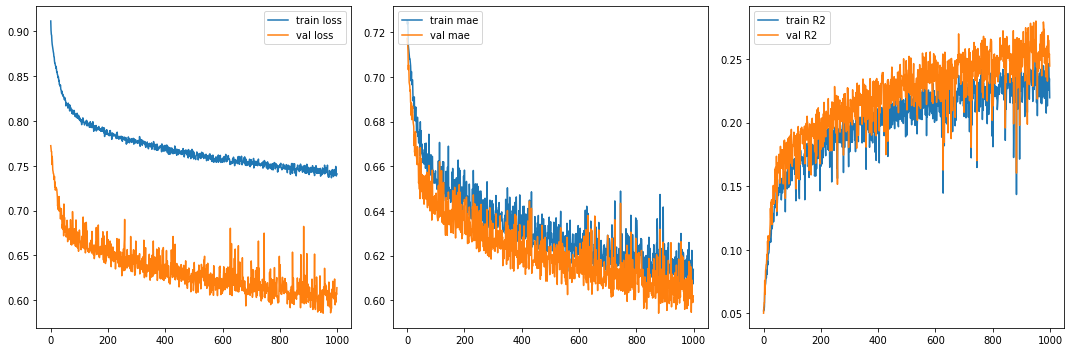

In [182]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].plot(train_losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend(loc="upper right")

axes[1].plot(train_maes, label="train mae")
axes[1].plot(val_maes, label="val mae")
axes[1].legend(loc="upper left")

axes[2].plot(train_r2s, label="train R2")
axes[2].plot(val_r2s, label="val R2")
axes[2].legend(loc="upper left")

fig.tight_layout()


## **Test evaluation**

In [186]:
model = torch.load("/content/model_min_mse.pt")
_, test_mae, test_mse, test_r2 = evaluate_model(testLoader, model)
print(f"test mae = {test_mae.round(3)}", f" | test mse = {test_mse.round(4)}", f" | test R2 = {test_r2.round(4)}")


test mae = 0.62  | test mse = 0.668  | test R2 = 0.2638


In [184]:
from sklearn.linear_model import LinearRegression
LRmodel = LinearRegression()
LRmodel.fit(X_train,y_train)
y_pred = LRmodel.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred) 
R2 = r2_score(y_test, y_pred) 
print("Linear Regression Results:")
print(f"test MAE = {mae.round(4)} ", f" | test MSE = {mse.round(4)}", f" | test R2 = {R2.round(4)}")

Linear Regression Results:
test MAE = 0.738   | test MSE = 0.8619  | test R2 = 0.05
